In [2]:
%load_ext autoreload
%autoreload 2

In this notebook I look at SHAP values in the context of simple linear models and index models to make its behaviour transparent in environments that econometricians are familiar with. I will consider 
1. Linear model with independent covariates
2. Linear model with dependent covariates
3. Index model (logit) with independent covariates
4. Index model (logit) with dependent covariates

### Linear model

see goodnotes.

### Logit

With the logit, there is no nice closed form solution for the conditional expected value of the prediction. Here, I will compute these integrals exactly using numerical integration through scipy. Alternatively, and probably much faster, would be to Monte-Carlo approximate those integrals.

In [10]:
import numpy as np
import scipy.integrate as integrate
from scipy.stats import multivariate_normal as mvn
from scipy.stats import norm

In [11]:
def get_sigma_decomposition(conditioning_indices, Sigma):
    """
    Decomposes the covariance matrix Sigma into three submatrices based on the conditioning indices.
    cf: https://stats.stackexchange.com/questions/30588/deriving-the-conditional-distributions-of-a-multivariate-normal-distribution

    Parameters:
    conditioning_indices (list): List of indices representing the conditioning variables.
    Sigma (numpy.ndarray): Covariance matrix.

    Returns:
    Sigma11 (numpy.ndarray): Submatrix of Sigma containing the non-conditioning variables.
    Sigma12 (numpy.ndarray): Submatrix of Sigma containing the cross-covariance between non-conditioning and conditioning variables.
    Sigma22 (numpy.ndarray): Submatrix of Sigma containing the conditioning variables.
    """
    non_conditioning_indices = [i for i in range(Sigma.shape[0]) if i not in conditioning_indices]
    Sigma11 = Sigma[np.ix_(non_conditioning_indices, non_conditioning_indices)]
    Sigma12 = Sigma[np.ix_(non_conditioning_indices, conditioning_indices)]
    Sigma22 = Sigma[np.ix_(conditioning_indices, conditioning_indices)]
    return Sigma11, Sigma12, Sigma22

# densities of conditional normal functions
def get_conditional_params(values, conditioning_var_inds=[1, 2], mus=np.array([0, 0, 0]), Sigma=np.array([[1, 0, 0], [0, 1, 0], [0, 0, 1]])):
    """
    Calculate the expected value and variance of a conditional normal distribution.

    Parameters:
    values (list): The observed values of the conditioning variables.
    conditioning_var_inds (list): The indices of the conditioning variables.
    mus (ndarray): The mean vector of the joint normal distribution.
    Sigma (ndarray): The covariance matrix of the joint normal distribution.

    Returns:
    tuple: A tuple containing the expected value and variance of the conditional normal distribution.
    """
    
    assert(len(values) == len(conditioning_var_inds))

    # generate list of variables by length of mus
    free_var_inds = [i for i in range(len(mus)) if i not in conditioning_var_inds]

    # get Sigma decomposition
    Sigma11, Sigma12, Sigma22 = get_sigma_decomposition(conditioning_var_inds, Sigma)
    # get expected value and variance of conditional normal distribution
    exp = mus[free_var_inds] + np.dot(Sigma12, np.dot(np.linalg.inv(Sigma22), (np.array(values) - mus[conditioning_var_inds])))
    sig = Sigma11 - np.dot(Sigma12, np.dot(np.linalg.inv(Sigma22), Sigma12.T))
    return exp, sig

def normal_conditional_density(x, conditioning_values, conditioning_indices, params={"mus": np.array([0, 0, 0]), "Sigma": np.array([[1, 0, 0], [0, 1, 0], [0, 0, 1]])}):
    """
    Calculates the conditional density of a multivariate normal distribution.

    Parameters:
    x (array-like): The value at which to evaluate the density.
    conditioning_values (array-like): The values of the conditioning variables.
    conditioning_indices (array-like): The indices of the conditioning variables.

    Returns:
    float: The value of the conditional density at x.
    """
    exp, sig = get_conditional_params(conditioning_values, conditioning_indices, mus=params["mus"], Sigma=params["Sigma"])
    assert(len(conditioning_values) == len(conditioning_indices))
    return mvn.pdf(x, mean=exp, cov=sig)


# logit
def f_logit(x, conditioning_values, conditioning_indices, coefs = np.array([1, 1, 1])):
    # select coefs using conditioning_indices and multiply with conditioning_values
    w = coefs[conditioning_indices]
    summand = np.dot(w, conditioning_values)
    # get remaining coefs
    if x is not None:
        w_remaining = coefs[[i for i in range(len(coefs)) if i not in conditioning_indices]]
        summand += np.dot(w_remaining, x)
    return np.sum(np.exp(summand)/(1 + np.exp(summand))) # sum to return scalar

In [12]:
get_conditional_params([1,0],[0,2])

(array([0.]), array([[1.]]))

In [13]:
# integrals for 3 variables
def E_f(values, conditioning_vars, params={"mus": np.array([0, 0, 0]), "Sigma": np.array([[1, 0, 0], [0, 1, 0], [0, 0, 1]]), "coefs": np.array([1, 1, 1])}):
    """
    Calculate the expected value of an outcome function f_logit under different conditioning variables with normal distributions for arbitrary parameters.

    Parameters:
    values (list): List of values for the conditioning variables.
    conditioning_vars (list): List of indices of the conditioning variables.
    params (dict): Dictionary of parameters for the function f_logit.

    Returns:
    tuple: A tuple containing the result and error of the calculation.
    """
    abs_error_tolerance = 1.49e-08
    assert(len(values) == len(conditioning_vars))
    normal_params = {"mus": params["mus"], "Sigma": params["Sigma"]}

    if len(conditioning_vars) == 3:
        result = f_logit(x = None, conditioning_values=values, conditioning_indices=conditioning_vars)
        error = None

    if len(conditioning_vars) == 2:
        result, error = integrate.quad(lambda x: normal_conditional_density(x, conditioning_values=values, conditioning_indices=conditioning_vars, params=normal_params) * f_logit(x, conditioning_values=values, conditioning_indices=conditioning_vars, coefs=params["coefs"]), -100, 100, epsabs=abs_error_tolerance, epsrel=abs_error_tolerance)
    
    if len(conditioning_vars) == 1:
        result, error = integrate.dblquad(lambda x,y: normal_conditional_density((x,y), conditioning_values=values, conditioning_indices=conditioning_vars, params=normal_params) * f_logit((x,y), conditioning_values=values, conditioning_indices=conditioning_vars, coefs=params["coefs"]), -100, 100, -100, 100, epsabs=abs_error_tolerance, epsrel=abs_error_tolerance)

    if len(conditioning_vars) == 0:
        if np.allclose(params["mus"], np.array([0, 0, 0])):
            result = 0.5
            error = None
        else:
            result, error = integrate.tplquad(lambda x,y,z: mvn.pdf((x,y,z), mean=params["mus"], cov=params["Sigma"]) * f_logit((x,y,z), conditioning_values=values, conditioning_indices=conditioning_vars, coefs=params["coefs"]), -100, 100, -100, 100, -100, 100, epsabs=abs_error_tolerance, epsrel=abs_error_tolerance)

    return result, error


Note that this function could be run just the same for another plug-in model simply by replacing the f_logit.

### checks and tests

In [35]:
coefs = np.array([1, 1, 1])
coefs[[1,2]]

array([1, 1])

In [36]:
f_logit(x = 2, conditioning_values = [0, 0], conditioning_indices = [1, 2], coefs = np.array([1, 1, 1]))

0.8807970779778824

In [37]:
f_logit(x = (0,0), conditioning_values = [0], conditioning_indices = [1], coefs = np.array([1, 1, 1]))

0.5

In [38]:
f_logit(x = (0,0,0), conditioning_values = [], conditioning_indices = [], coefs = np.array([1, 1, 1]))

0.5

In [8]:
get_sigma_decomposition([1,2], Sigma = np.array([[1,0,0],[0,1,0],[0,0,1]]))

(array([[1]]),
 array([[0, 0]]),
 array([[1, 0],
        [0, 1]]))

In [9]:
get_sigma_decomposition([2], Sigma = np.array([[1,0,0],[0,1,0],[0,0,1]]))

(array([[1, 0],
        [0, 1]]),
 array([[0],
        [0]]),
 array([[1]]))

In [10]:
get_conditional_params(values = [0], conditioning_var_inds = [2])

(array([0., 0.]),
 array([[1., 0.],
        [0., 1.]]))

In [11]:
normal_conditional_density(x = [0,0], conditioning_values=[0], conditioning_indices=[2])

0.15915494309189535

In [39]:
# check if the conditional densities are correct by integrating

integrate.dblquad(lambda x,y: normal_conditional_density((x,y), [0], [2]), -np.inf, np.inf, -np.inf, np.inf, epsabs=abs_error_tolerance, epsrel=abs_error_tolerance)

(1.0000000011805943, 0.0001413029331700994)

In [40]:
integrate.quad(lambda x: normal_conditional_density(x, [0,3], [1,2]), -np.inf, np.inf, epsabs=abs_error_tolerance, epsrel=abs_error_tolerance)

(0.9999999997941593, 9.361124086700034e-05)

In [41]:
integrate.quad(lambda x: f_logit(x, [0,0], [1,2]) * normal_conditional_density(x, [0,0], [1,2]), -100, 100)

(0.5000000000000001, 5.943013844712378e-13)

In [42]:
mvn.pdf((0,0,0), np.array([0,0,0]), np.array([[1,0,0],[0,1,0],[0,0,1]]))

0.06349363593424098

For some reason this only works if I throw in bounds of 100, for larger (e.g. np.inf) it doesnt compute the integral, I guess it has trouble with large values of the logic and small tail probability masses.

In [16]:
E_f(values = [1,2], conditioning_vars = [1,2])

(0.9306761419957146, 7.25675477206413e-13)

In [17]:
E_f(values = [1], conditioning_vars = [2])

(0.6750567023488913, 1.4870789199628173e-08)

### SHAP value computation via Kernel representation

The code is based on a description of the Kernel Shap procedure from KJERSTI AAS, MARTIN JULLUM, and ANDERS LØLAND in EXPLAINING INDIVIDUAL PREDICTIONS WHEN FEATURES ARE DEPENDENT:
MORE ACCURATE APPROXIMATIONS TO SHAPLEY VALUES.

In [14]:
import pandas as pd
import numpy as np
import math
import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

class ShapleyWLS:
    def __init__(self, SHAP_value_function, data_instance, value_function_params):
        self.SHAP_value_function = SHAP_value_function
        self.data_instance = data_instance
        self.value_function_params = value_function_params
        self.M = len(data_instance)
        self.Z = None
        self.W = None
        self.v = None
        self.shapley_values = None

    def build_Z(self):
        self.Z = np.ones((2**self.M, self.M+1))
        self.Z[:, 1:] = np.unpackbits(np.arange(2**self.M, dtype=np.uint8)[:, np.newaxis], axis=1)[:, -self.M:]
        print("Z built.")

    def build_W(self):
        self.W = np.zeros((2**self.M, 2**self.M))
        for i in range(2**self.M):
            sum_Z = int(np.sum(self.Z[i, 1:]))
            if sum_Z == 0 or sum_Z == self.M:
                self.W[i, i] = 10e7 # should be infinity, in practice set to large constant
            else:
                self.W[i, i] = (self.M-1)/(math.comb(self.M, sum_Z) * (self.M-sum_Z) * sum_Z)
        print("W built.")

    def build_v(self):
        self.v = np.zeros((2**self.M, 1))
        for i in tqdm.tqdm(range(2**self.M)):
            conditioning_indices = np.where(self.Z[i, 1:] == 1)[0] # indices of "playing" features
            self.v[i] = self.SHAP_value_function(values = self.data_instance[conditioning_indices] , conditioning_vars = conditioning_indices, params = self.value_function_params)[0]
            print(f"v_{i}: {self.v[i]}")

    def compute_shapley_values(self):
        self.build_Z()
        self.build_W()
        self.build_v()
        self.shapley_values = np.dot(np.dot(np.dot(np.linalg.inv(np.dot(np.dot(self.Z.T, self.W), self.Z)), self.Z.T), self.W), self.v)
        return self.shapley_values
    
    def get_prediction(self):
        return self.SHAP_value_function(values = self.data_instance, conditioning_vars = [0,1,2], params = self.value_function_params)[0]
    
    def plot_waterfall(self):
        assert self.shapley_values is not None; "Shapley values not computed yet."

         # get model prediction for the instance
        prediction = self.get_prediction()
        df = pd.DataFrame({"feature": ["default","x1", "x2", "x3"], "SHAP": self.shapley_values.flatten(), "value": np.insert(self.data_instance,0,0)})
        df["cumulative_SHAP"] = df["SHAP"].cumsum()

        # build waterfall plot
        f = plt.figure(figsize=(10, 5))
        sns.barplot(x="feature", y="cumulative_SHAP", data=df, color="lightblue", label="Cumulative SHAP", width = 0.2)
        sns.barplot(x="feature", y="SHAP", data=df, color = "green", width=0.8, alpha=0.5, label = "Individual SHAP")
        sns.scatterplot(x="feature", y="value", data=df, color="purple", alpha=0.6, label="Feature Value")
        ax = plt.gca()
        ax.axhline(prediction, color='blue', linewidth=2, linestyle='--', label = "Model Prediction")
        # annotate the SHAP bars with their value
        for i, v in enumerate(df["SHAP"]):
            ax.text(i, v, round(v, 2), ha='center', va='bottom')

        # add legend
        plt.legend()

        plt.show()

Let's try if this works in the logit for a (0,0,0) instance: all instances are equal to their individual expectation, so the default shap value $\phi(\emptyset) = 0.5$ and the other are all zero...

In [88]:
SHAP_WLS_test = ShapleyWLS(SHAP_value_function = E_f, data_instance = np.array([0,0,0]), value_function_params = {"mus": np.array([0, 0, 0]), "Sigma": np.array([[1, 0, 0], [0, 1, 0], [0, 0, 1]]), "coefs": np.array([1, 1, 1])})
SHAP_WLS_test.get_prediction()

0.5

In [89]:
sv0 = SHAP_WLS_test.compute_shapley_values()
sv0

Z built.
W built.


  0%|          | 0/8 [00:00<?, ?it/s]

v_0: [0.5]


 25%|██▌       | 2/8 [00:05<00:17,  2.95s/it]

v_1: [0.5]


 38%|███▊      | 3/8 [00:11<00:20,  4.17s/it]

v_2: [0.5]
v_3: [0.5]


100%|██████████| 8/8 [00:17<00:00,  2.24s/it]

v_4: [0.5]
v_5: [0.5]
v_6: [0.5]
v_7: [0.5]


array([[ 4.99999996e-01],
       [ 9.26233191e-09],
       [-4.01732103e-09],
       [-2.17707569e-09]])

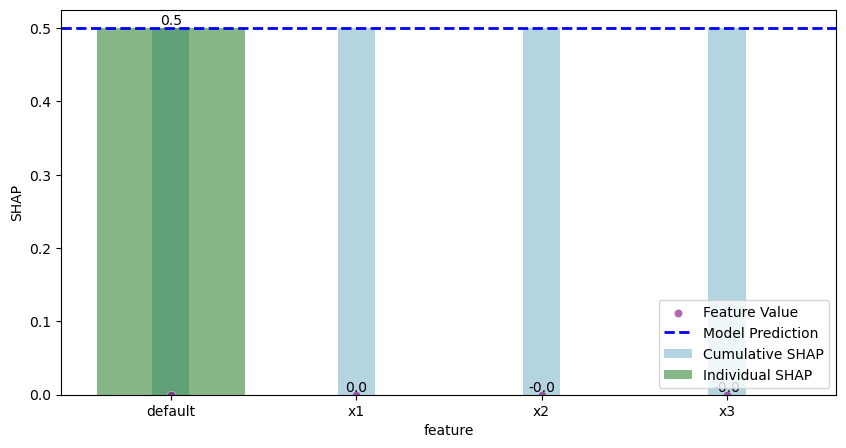

In [90]:
SHAP_WLS_test.plot_waterfall()

Lets now look at the case where we have a single feature that is 1 and the others are 0

In [91]:
SHAP_logit1 = ShapleyWLS(SHAP_value_function = E_f, data_instance = np.array([1,0,0]), value_function_params = {"mus": np.array([0, 0, 0]), "Sigma": np.array([[1, 0, 0], [0, 1, 0], [0, 0, 1]]), "coefs": np.array([1, 1, 1])})
sv1 = SHAP_logit1.compute_shapley_values()
sv1

Z built.
W built.


  0%|          | 0/8 [00:00<?, ?it/s]

v_0: [0.5]


 25%|██▌       | 2/8 [00:05<00:17,  2.98s/it]

v_1: [0.5]


 38%|███▊      | 3/8 [00:11<00:20,  4.15s/it]

v_2: [0.5]
v_3: [0.5]


100%|██████████| 8/8 [00:17<00:00,  2.23s/it]

v_4: [0.6750567]
v_5: [0.69673467]
v_6: [0.69673467]
v_7: [0.73105858]


array([[0.49999999],
       [0.20095   ],
       [0.01505429],
       [0.01505429]])

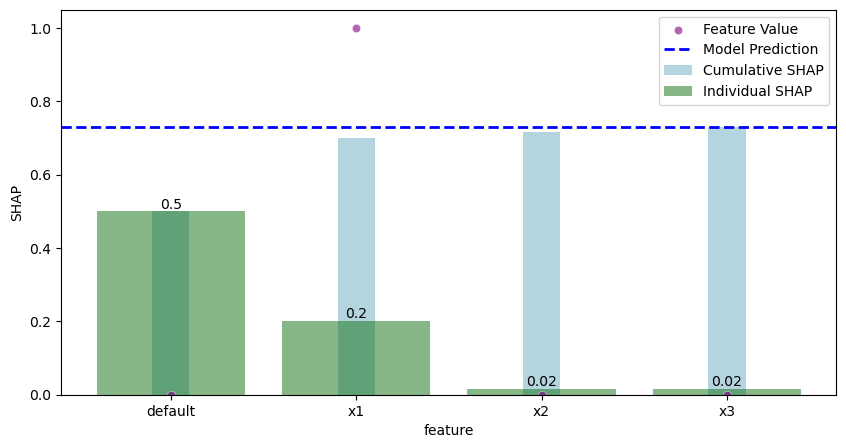

In [92]:
SHAP_logit1.plot_waterfall()

What is perhaps a little surprising here is that by setting feature x1 equal to 1, we also get small, but non-zero contribution from the zero features even though the covariates are themselves independent of one another. To see how this happens, consider one of the constituents of $\phi_2$, namely the marginal contribution of x2 in v(x1,x2) - v(x1). As soon as x1 > 0, this difference will become positive as the first term will grow more than the second term as a result of the non-linearity of f.

Looks good! Now consider the case where x1 is correlated with x2. Some of the attribution of x1 will be shifted to x2:
1. For the SHAP value of x1, for some coalitions the marginal contribution of x1 will be reduced because its lower than what one would expect based on observing x2
2. For the SHAP value of x2, for some coalitions the marginal contribution of x2 will be increased because its higher than what one would expect based on observing x1

In [18]:
SHAP_logit2 = ShapleyWLS(SHAP_value_function = E_f, data_instance = np.array([1,0,0]), value_function_params = {"mus": np.array([0, 0, 0]), "Sigma": np.array([[1, 0.7, 0], [0.7, 1, 0], [0, 0, 1]]), "coefs": np.array([1, 1, 1])})
SHAP_logit2.get_prediction()

0.7310585786300049

In [19]:
sv_logit2 = SHAP_logit2.compute_shapley_values()

Z built.
W built.


  0%|          | 0/8 [00:00<?, ?it/s]

v_0: [0.5]


 25%|██▌       | 2/8 [00:06<00:18,  3.09s/it]

v_1: [0.5]


 38%|███▊      | 3/8 [00:12<00:21,  4.34s/it]

v_2: [0.5]
v_3: [0.5]


100%|██████████| 8/8 [00:18<00:00,  2.33s/it]

v_4: [0.79146488]
v_5: [0.82424899]
v_6: [0.69673467]
v_7: [0.73105858]


In [20]:
SHAP_logit2.shapley_values

array([[ 0.49999999],
       [ 0.26100511],
       [-0.04685184],
       [ 0.01690532]])

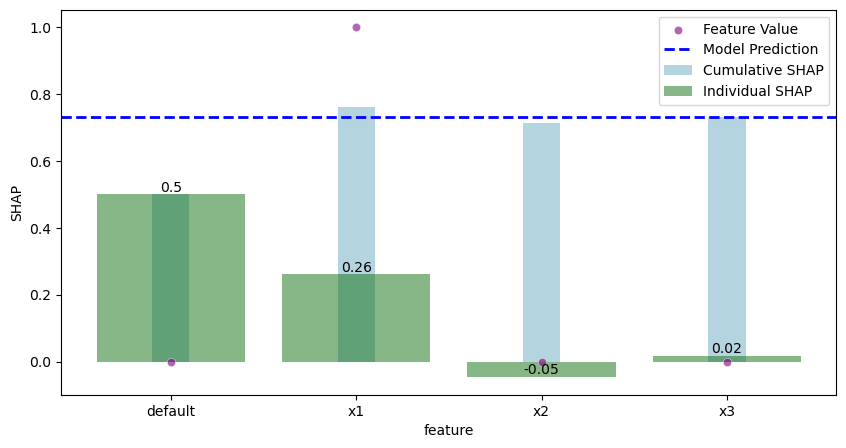

In [21]:
SHAP_logit2.plot_waterfall()

In [15]:
logit_another_test = ShapleyWLS(SHAP_value_function = E_f, data_instance = np.array([0,10,0]), value_function_params = {"mus": np.array([0, 0, 0]), "Sigma": np.array([[1, 0, 0], [0, 1, 0], [0, 0, 1]]), "coefs": np.array([1, 1, 1])})
logit_another_test.get_prediction()

0.9999546021312976

In [16]:
sv3 = logit_another_test.compute_shapley_values()
sv3

Z built.
W built.


  0%|          | 0/8 [00:00<?, ?it/s]

v_0: [0.5]


 25%|██▌       | 2/8 [00:06<00:18,  3.03s/it]

v_1: [0.5]


 38%|███▊      | 3/8 [00:12<00:21,  4.35s/it]

v_2: [0.9998767]
v_3: [0.99992516]


100%|██████████| 8/8 [00:18<00:00,  2.31s/it]

v_4: [0.5]
v_5: [0.5]
v_6: [0.99992516]
v_7: [0.9999546]


array([[4.99999991e-01],
       [1.79095716e-05],
       [4.99918812e-01],
       [1.78866939e-05]])

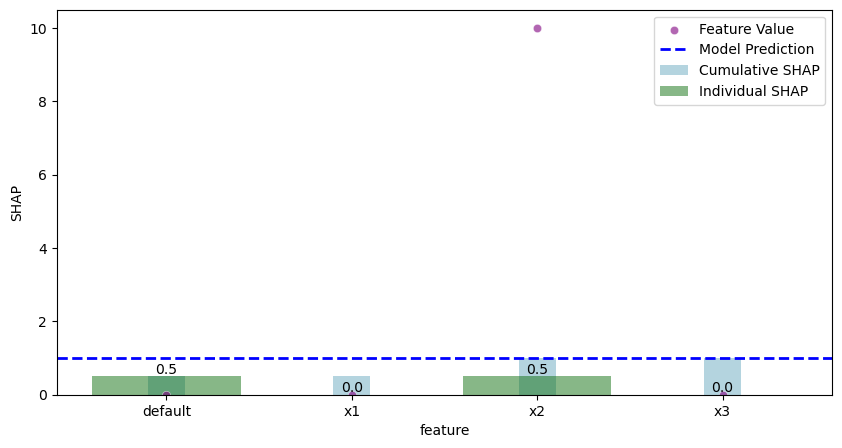

In [17]:
logit_another_test.plot_waterfall()